In [ ]:
import scipy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

[[ 1.  1.]
 [-1.  1.]
 [-1. -1.]
 [ 1. -1.]]
subInput
(4, 20)
The Rank of a Matrix:  2
The Rank of a Matrix:  2


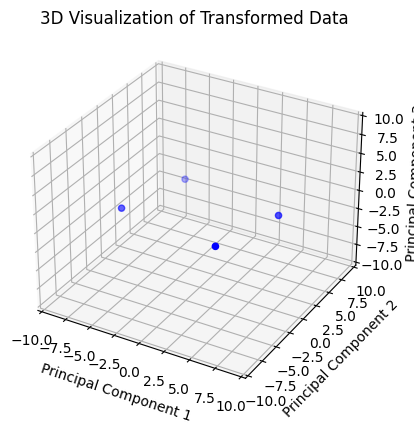

The Rank of a Matrix:  2


In [ ]:
# INPUT
cond = np.zeros((4,2))
cond[0,:] = [1,1]
cond[1,:] = [-1,1]
cond[2,:] = [-1,-1]
cond[3,:] = [1,-1]

print(cond)

cond = cond.T

# parameters
sigma = 1
N = 20
T = 100
numCond = 4
noise_var = 2

subInput = np.zeros((numCond, N))
W = scipy.stats.norm.rvs(loc=0, scale=sigma, size=[N,2])
subInput[0,:] = W @ cond[:,0] # = np.matmul()
subInput[1,:] = W @ cond[:,1]
subInput[2,:] = W @ cond[:,2]
subInput[3,:] = W @ cond[:,3]

print("subInput")
print(subInput.shape)

print("The Rank of a Matrix: ", np.linalg.matrix_rank(W))  # 2
print("The Rank of a Matrix: ", np.linalg.matrix_rank(subInput)) # 2

# control - to make sure that the matrix that has been projected to the N=20 has also the rank of 2
pca = PCA(n_components = 3)

transformed_data = pca.fit_transform(subInput)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the transformed data
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c='b', marker='o')

# Set labels and title (axis is important)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Transformed Data')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])

plt.show()

print("The Rank of a Matrix: ", np.linalg.matrix_rank(transformed_data))

In [ ]:
# Add noise
input = np.zeros((numCond,T,N))
# Project 'the square' to the N-dimensional space
W = stats.norm.rvs(loc=0, scale=sigma, size=[N,2]) # this should go below
for i in range(T): # T = 100 trials
    input[0,i,:] = W @ cond[:,0] # V (N x 1) = W (N x 2) * I (2 x 1)
    input[1,i,:] = W @ cond[:,1]
    input[2,i,:] = W @ cond[:,2]
    input[3,i,:] = W @ cond[:,3]

# add very small Gaussian noise
noise_matrix = np.random.normal(loc=0, scale=noise_var, size=input.shape)
input_w_noise = input + noise_matrix

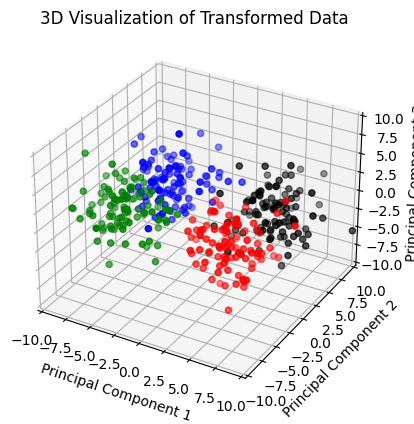

In [ ]:
# reshape
input_dis = np.vstack((input_w_noise[0,:,:], input_w_noise[1,:,:], input_w_noise[2,:,:], input_w_noise[3,:,:]))

# PCA
pca = PCA(n_components = 3)
transformed_data = pca.fit_transform(input_dis)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the transformed data
for _, (idx, color) in enumerate(zip(range(4), ['r','g','b','k'])):
    ax.scatter(transformed_data[idx*100:(idx+1)*100, 0],
               transformed_data[idx*100:(idx+1)*100, 1],
               transformed_data[idx*100:(idx+1)*100, 2],
               c=color, marker='o')

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Transformed Data')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])

plt.show()

## Build Network

In [ ]:
input_dis.shape

(400, 20)

In [ ]:
# Create target (reference) data
cond0 = np.zeros(200)
cond1 = np.ones(200)
target_case1 = np.hstack((cond0, cond1)) # dim 1 classification
print("Size of target data case 1: {}".format(target_case1.shape))

c0 = np.zeros(100)
target_case2 = np.hstack((c0, cond1, c0)) # dim 2 classification
print("Size of target data case 2: {}".format(target_case2.shape))

c3 = np.ones(100)
target_case3 = np.hstack((c0, c3, c0, c3)) # diagonal classification
print("Size of target data case 3: {}".format(target_case3.shape))

Size of target data case 1: (400,)
Size of target data case 2: (400,)
Size of target data case 3: (400,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

In [ ]:
def run_simple(input_dis, target_case, input_dim, output_dim, batchsize, num_epochs, learning_rate):

  input_tensor = torch.tensor(input_dis, dtype=torch.float32)
  target_tensor = torch.tensor(target_case, dtype=torch.long)

  hidden_dim = input_dim * 2

  # Create a TensorDataset and DataLoader
  dataset = TensorDataset(input_tensor, target_tensor)

  # Define the size of train and test sets
  train_size = int(0.7 * len(dataset))
  test_size = len(dataset) - train_size

  # Split the dataset
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

  # Create train and test dataloaders
  train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True) # shuffle the training dataset every time it starts a new epoch
  test_loader = DataLoader(test_dataset, batch_size = batchsize, shuffle=False)

  # Create Pytorch model
  class SimpleNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
      super(SimpleNN, self).__init__()
      self.input_layer = nn.Linear(input_dim, output_dim)
      # self.input_layer = nn.Linear(input_dim, hidden_dim)
      # self.hidden_layer = nn.Linear(hidden_dim, output_dim) # here, I can add noise to make noises in the hidden layer

    def forward(self, x):
      x = F.relu(self.input_layer(x)) # Applying ReLU activation after input_layer
      # x = self.hidden_layer(x) # currently does not have softmax activation (But F.softmax is possible depending on the model)
      return x

  # Create an instance of a model
  model = SimpleNN(input_dim, hidden_dim, output_dim)
  print(model)

  # Loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate) # this is where I will add regularization metrics

  # Training loop
  trainLosses = []
  valLosses = []
  accuracies = []

  for epoch in range(num_epochs): # for every epoch

    # train set up
    model.train()
    train_loss = 0 # for every epoch, the loss is added across all batches

    for inputs, targets in train_loader: # During each epoch's training loop, when you iterate through 'train loader'
                                        # the batches ('inputs' and 'targets') are provided in a shuffled order.
                                        # this means that the order of data samples within each batch is randomized compared to the previous epoch

      inputs = inputs.float()

      # clear the gradients
      optimizer.zero_grad()

      # Apply the model
      output = model(inputs)

      # Compute the loss
      loss = lossfun(output, targets)

      # Backpropagation
      loss.backward()

      # Update the weights
      optimizer.step()

      # Add loss
      train_loss += loss.item()

    # Just showing how it increments
    if (epoch+1) % 1 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')

    avg_train_loss = train_loss / len(train_loader)
    trainLosses.append(avg_train_loss)

  # Evaluation phase
  # Can the loss decrease even if the accuracy is not good?

    model.eval()
    val_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad(): # no need to track gradients during evaluation

      for inputs, targets in test_loader:

        # test input
        testoutput = model(inputs)

        # find the validation loss
        loss = lossfun(testoutput, targets)
        val_loss += loss.item()

        # Get the max output?
        _, predicted = torch.max(testoutput, 1)

        print("targets", targets)
        print("predicted", predicted)

        # store the result
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      accuracy = correct / total
      accuracies.append(accuracy)
      print(f'Accuracy: {accuracy:.4f}')

    # Average validation loss for this epoch
    avg_val_loss = val_loss / len(test_loader)
    valLosses.append(avg_val_loss)


  # Plot train loss and validation loss and accuracy
  epoch_nums = np.arange(num_epochs)+1

  fig, axs = plt.subplots(1,2, figsize=(12,5))

  axs[0].plot(epoch_nums, trainLosses, 'r')
  axs[0].plot(epoch_nums, valLosses, 'b')
  axs[0].set_title("Loss")
  axs[0].set_xlabel("Epoch num")
  axs[0].set_ylabel("Loss")
  axs[0].legend(['Train loss', 'Validation loss'])

  axs[1].plot(epoch_nums, accuracies, 'g')
  axs[1].set_title("Accuracy")
  axs[1].set_xlabel("Epoch num")
  axs[1].set_ylabel("Accuracy")
  axs[1].set_ylim([0, 1])

  plt.show()

SimpleNN(
  (input_layer): Linear(in_features=20, out_features=2, bias=True)
)
Epoch [1/40], Loss: 0.8517
Accuracy: 0.4750
Epoch [2/40], Loss: 0.8094
Accuracy: 0.4750
Epoch [3/40], Loss: 0.7750
Accuracy: 0.4667
Epoch [4/40], Loss: 0.7475
Accuracy: 0.4917
Epoch [5/40], Loss: 0.7221
Accuracy: 0.5000
Epoch [6/40], Loss: 0.6997
Accuracy: 0.5250
Epoch [7/40], Loss: 0.6820
Accuracy: 0.5167
Epoch [8/40], Loss: 0.6666
Accuracy: 0.5250
Epoch [9/40], Loss: 0.6527
Accuracy: 0.5333
Epoch [10/40], Loss: 0.6396
Accuracy: 0.5417
Epoch [11/40], Loss: 0.6291
Accuracy: 0.5417
Epoch [12/40], Loss: 0.6183
Accuracy: 0.5333
Epoch [13/40], Loss: 0.6086
Accuracy: 0.5333
Epoch [14/40], Loss: 0.5994
Accuracy: 0.5250
Epoch [15/40], Loss: 0.5914
Accuracy: 0.5250
Epoch [16/40], Loss: 0.5840
Accuracy: 0.5333
Epoch [17/40], Loss: 0.5775
Accuracy: 0.5583
Epoch [18/40], Loss: 0.5717
Accuracy: 0.5667
Epoch [19/40], Loss: 0.5666
Accuracy: 0.5667
Epoch [20/40], Loss: 0.5621
Accuracy: 0.5667
Epoch [21/40], Loss: 0.5563
Ac

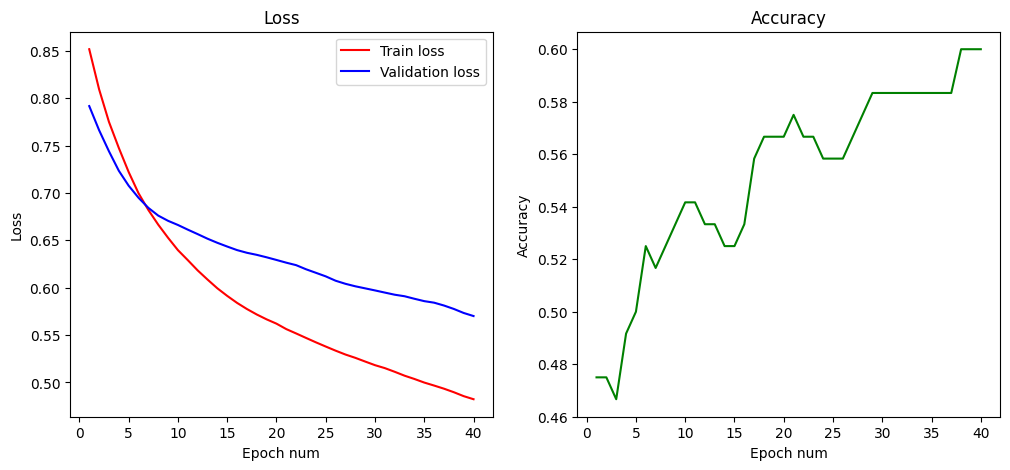

In [ ]:
run_simple(input_dis = input_dis,
           target_case = target_case3,
           input_dim = 20,
           output_dim = 2,
           batchsize = 20,
           num_epochs = 40,
           learning_rate = 0.001)

K-Fold implemented

In [ ]:
# from sklearn.model_selection import KFold

In [ ]:
# def run_simple_cv(input_dis, target_case, input_dim, output_dim, batchsize, num_epochs, learning_rate, k_folds):

#     input_tensor = torch.tensor(input_dis, dtype=torch.float32)
#     target_tensor = torch.tensor(target_case, dtype=torch.long)

#     # Set basic parameters
#     hidden_dim = input_dim * 2

#     # Create a TensorDataset
#     dataset = TensorDataset(input_tensor, target_tensor)

#     # Define the KFold cross validator
#     kfold = KFold(n_splits = k_folds, shuffle=True)

#     # Create a Pytorch model class
#     class SimpleNN(nn.Module):
#         def __init__(self, input_dim, hidden_dim, output_dim):
#             super(SimpleNN, self).__init__()
#             self.input_layer = nn.Linear(input_dim, hidden_dim)
#             self.hidden_layer = nn.Linear(hidden_dim, output_dim)

#         def forward(self, x):
#             x = F.relu(self.input_layer(x))
#             x = self.hidden_layer(x)
#             return x

#     trainLosses = []
#     valLosses = []
#     accuracies = []
#     epoch_mean_trainLosses = []
#     epoch_mean_valLosses = []

#     # K-fold cross validation model evaluation
#     for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):

#       print(f'Fold {fold+1}')
#       print('-----------------------------')

#       # Sample elements randomly from a given list of indices, no replacement
#       train_subsampler = Subset(dataset, train_idx)
#       val_subsampler = Subset(dataset, val_idx)

#       # Data loaders
#       train_loader = DataLoader(train_subsampler, batch_size = batchsize, shuffle=True)
#       val_loader = DataLoader(val_subsampler, batch_size = batchsize, shuffle=False)

#       # Instantiate the model
#       model = SimpleNN(input_dim, hidden_dim, output_dim)
#       # print(model)

#       # Loss function and optimizer
#       lossfun = nn.CrossEntropyLoss()
#       optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#       trainLoss_per_epoch = []
#       valLoss_per_epoch = []

#       # Training loop
#       for epoch in range(num_epochs):

#         model.train()
#         train_loss = 0

#         for inputs, targets in train_loader:

#           # zero out the optimizer weights
#           optimizer.zero_grad()

#           output = model(inputs)
#           loss = lossfun(output, targets)
#           loss.backward()
#           optimizer.step()

#           train_loss += loss.item()

#         avg_train_loss = train_loss/len(train_loader)
#         trainLosses.append(avg_train_loss)
#         trainLoss_per_epoch.append(avg_train_loss)

#         model.eval()
#         val_loss = 0
#         total = 0
#         correct = 0

#         with torch.no_grad():
#           for inputs, targets in val_loader:

#             testoutput = model(inputs)
#             loss = lossfun(testoutput, targets)
#             val_loss += loss.item()

#             _, predicted = torch.max(testoutput, 1)

#             # storage
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()

#         avg_val_loss = val_loss/len(val_loader)
#         valLoss_per_epoch.append(avg_val_loss)
#         valLosses.append(avg_val_loss)

#         accuracy = correct/total
#         accuracies.append(accuracy)

#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}')


#       trainLoss_per_epoch.append(np.mean(trainLoss_per_epoch))
#       print("Again, fold number", fold)
#       valLoss_per_epoch.append(np.mean(valLoss_per_epoch))


#     return trainLosses, valLosses, accuracies, trainLoss_per_epoch, valLoss_per_epoch

In [ ]:
# trainLosses, valLosses, accuracies, trainLoss_per_epoch, valLoss_per_epoch= run_simple_cv(input_dis = input_dis,
#                                                                                           target_case = target_case1,
#                                                                                           input_dim = 20,
#                                                                                           output_dim = 2,
#                                                                                           batchsize = 20,
#                                                                                           num_epochs = 10,
#                                                                                           learning_rate = 0.001,
#                                                                                           k_folds=5)

In [ ]:
# plt.plot(trainLoss_per_epoch)
# plt.plot(valLoss_per_epoch)

In [ ]:
#     # Plot train loss, validation loss, and accuracy
# epoch_nums = np.arange(1, 50 + 1)
# plt.plot(epoch_nums, trainLosses, 'r', label='Train loss')
# plt.plot(epoch_nums, valLosses, 'b', label='Validation loss')
# # plt.plot(epoch_nums, accuracies, 'g', label='Accuracy')
# plt.title("Loss and Accuracy per Epoch")
# plt.xlabel("Epoch num")
# plt.ylabel("Loss/Accuracy")
# plt.legend()
# plt.show()